# Models Comparison for TinyML

In [1]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
# Change this to change subtask
taskIndex = 2

In [3]:
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [4]:
n_labels = 2 + taskIndex
samples = 30
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [5]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [6]:
y = np.array([int(el) for el in y])
print(y)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test.shape)
print(y_test.shape)


(24, 42)
(24,)


In [8]:
y_test

array([2, 2, 2, 3, 1, 0, 1, 0, 1, 2, 3, 3, 0, 1, 3, 2, 2, 1, 0, 0, 1, 3,
       0, 3])

## Model Spotting

In [9]:
# Test options and evaluation metric
num_folds = 5
seed = 42
scoring = 'f1_macro'

In [32]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.9999, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=150, 
                                                           max_features=2, criterion='gini', max_depth=None,
                                                           min_samples_split=2, min_samples_leaf=1)))



In [33]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,40 0,08
LR - 0,61 0,04
CART - 0,66 0,10
SVC - 0,68 0,05
RF - 0,76 0,09


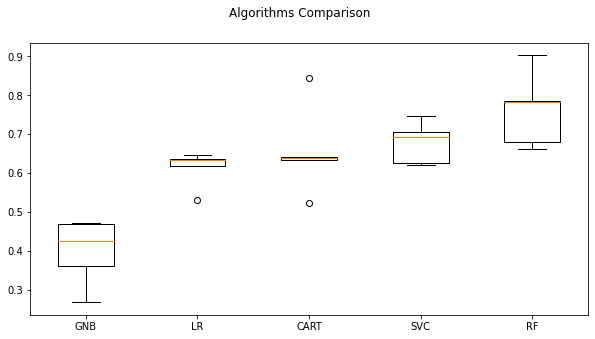

In [34]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [35]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if taskIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[taskIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    #classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.50      0.17      0.25         6
           2       0.67      0.33      0.44         6
           3       0.29      0.67      0.40         6

    accuracy                           0.46        24
   macro avg       0.56      0.46      0.46        24
weighted avg       0.56      0.46      0.46        24

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.57      0.67      0.62         6
           2       0.33      0.17      0.22         6
           3       0.80      0.67      0.73         6

    accuracy                           0.58        24
   macro avg       0.57      0.58      0.56        24
weighted avg       0.57      0.58      0.56        24

---------------------------------------------

# Neural Network

In [52]:
#Hyperparameters of NN
EPOCHS = 500 
BATCH_SIZE = 7
learn_rate = 0.001
nodes = 512
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))    
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [53]:
num_folds = 5

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_14 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               22016     
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 2052      
Total params: 25,874
Trainable params: 25,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 0s 671us/step - loss: 1.3867 - accuracy: 0.3289
Epoch 2/500
11

11/11 [==============================] - 0s 532us/step - loss: 0.0492 - accuracy: 1.0000
Epoch 72/500
11/11 [==============================] - 0s 698us/step - loss: 0.0756 - accuracy: 0.9605
Epoch 73/500
11/11 [==============================] - 0s 585us/step - loss: 0.0638 - accuracy: 1.0000
Epoch 74/500
11/11 [==============================] - 0s 647us/step - loss: 0.0653 - accuracy: 0.9868
Epoch 75/500
11/11 [==============================] - 0s 565us/step - loss: 0.0305 - accuracy: 1.0000
Epoch 76/500
11/11 [==============================] - 0s 685us/step - loss: 0.0359 - accuracy: 0.9868
Epoch 77/500
11/11 [==============================] - 0s 560us/step - loss: 0.0589 - accuracy: 0.9737
Epoch 78/500
11/11 [==============================] - 0s 704us/step - loss: 0.0633 - accuracy: 0.9868
Epoch 79/500
11/11 [==============================] - 0s 567us/step - loss: 0.0840 - accuracy: 0.9737
Epoch 80/500
11/11 [==============================] - 0s 700us/step - loss: 0.0391 - accuracy: 

11/11 [==============================] - 0s 584us/step - loss: 0.0090 - accuracy: 1.0000
Epoch 151/500
11/11 [==============================] - 0s 652us/step - loss: 0.0102 - accuracy: 1.0000
Epoch 152/500
11/11 [==============================] - 0s 568us/step - loss: 0.0148 - accuracy: 1.0000
Epoch 153/500
11/11 [==============================] - 0s 631us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 154/500
11/11 [==============================] - 0s 535us/step - loss: 0.0220 - accuracy: 1.0000
Epoch 155/500
11/11 [==============================] - 0s 663us/step - loss: 0.0238 - accuracy: 1.0000
Epoch 156/500
11/11 [==============================] - 0s 573us/step - loss: 0.0251 - accuracy: 0.9868
Epoch 157/500
11/11 [==============================] - 0s 731us/step - loss: 0.0122 - accuracy: 1.0000
Epoch 158/500
11/11 [==============================] - 0s 535us/step - loss: 0.0083 - accuracy: 1.0000
Epoch 159/500
11/11 [==============================] - 0s 637us/step - loss: 0.0113 - a

11/11 [==============================] - 0s 632us/step - loss: 0.0076 - accuracy: 1.0000
Epoch 230/500
11/11 [==============================] - 0s 604us/step - loss: 0.0112 - accuracy: 1.0000
Epoch 231/500
11/11 [==============================] - 0s 660us/step - loss: 0.0104 - accuracy: 1.0000
Epoch 232/500
11/11 [==============================] - 0s 563us/step - loss: 0.0088 - accuracy: 1.0000
Epoch 233/500
11/11 [==============================] - 0s 670us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 234/500
11/11 [==============================] - 0s 541us/step - loss: 0.0101 - accuracy: 1.0000
Epoch 235/500
11/11 [==============================] - 0s 735us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 236/500
11/11 [==============================] - 0s 565us/step - loss: 0.0093 - accuracy: 1.0000
Epoch 237/500
11/11 [==============================] - 0s 648us/step - loss: 0.0154 - accuracy: 1.0000
Epoch 238/500
11/11 [==============================] - 0s 549us/step - loss: 0.0199 - a

11/11 [==============================] - 0s 542us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 309/500
11/11 [==============================] - 0s 689us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 310/500
11/11 [==============================] - 0s 566us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 311/500
11/11 [==============================] - 0s 671us/step - loss: 0.0041 - accuracy: 1.0000
Epoch 312/500
11/11 [==============================] - 0s 566us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 313/500
11/11 [==============================] - 0s 715us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 314/500
11/11 [==============================] - 0s 565us/step - loss: 0.0053 - accuracy: 1.0000
Epoch 315/500
11/11 [==============================] - 0s 659us/step - loss: 0.0117 - accuracy: 1.0000
Epoch 316/500
11/11 [==============================] - 0s 543us/step - loss: 0.0112 - accuracy: 1.0000
Epoch 317/500
11/11 [==============================] - 0s 686us/step - loss: 0.0084 - a

11/11 [==============================] - 0s 619us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 388/500
11/11 [==============================] - 0s 597us/step - loss: 0.0110 - accuracy: 1.0000
Epoch 389/500
11/11 [==============================] - 0s 582us/step - loss: 0.0194 - accuracy: 0.9868
Epoch 390/500
11/11 [==============================] - 0s 567us/step - loss: 8.5357e-04 - accuracy: 1.0000
Epoch 391/500
11/11 [==============================] - 0s 674us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 392/500
11/11 [==============================] - 0s 560us/step - loss: 0.0175 - accuracy: 0.9868
Epoch 393/500
11/11 [==============================] - 0s 630us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 394/500
11/11 [==============================] - 0s 543us/step - loss: 0.0086 - accuracy: 1.0000
Epoch 395/500
11/11 [==============================] - 0s 647us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 396/500
11/11 [==============================] - 0s 517us/step - loss: 0.0016

11/11 [==============================] - 0s 642us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 467/500
11/11 [==============================] - 0s 585us/step - loss: 8.2448e-04 - accuracy: 1.0000
Epoch 468/500
11/11 [==============================] - 0s 707us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 469/500
11/11 [==============================] - 0s 557us/step - loss: 6.8128e-04 - accuracy: 1.0000
Epoch 470/500
11/11 [==============================] - 0s 693us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 471/500
11/11 [==============================] - 0s 540us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 472/500
11/11 [==============================] - 0s 721us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 473/500
11/11 [==============================] - 0s 583us/step - loss: 6.1735e-04 - accuracy: 1.0000
Epoch 474/500
11/11 [==============================] - 0s 615us/step - loss: 8.1713e-04 - accuracy: 1.0000
Epoch 475/500
11/11 [==============================] - 0s 512us/step - 

11/11 [==============================] - 0s 515us/step - loss: 0.3429 - accuracy: 0.9351
Epoch 29/500
11/11 [==============================] - 0s 591us/step - loss: 0.3657 - accuracy: 0.8701
Epoch 30/500
11/11 [==============================] - 0s 525us/step - loss: 0.3756 - accuracy: 0.8831
Epoch 31/500
11/11 [==============================] - 0s 592us/step - loss: 0.2901 - accuracy: 0.9351
Epoch 32/500
11/11 [==============================] - 0s 497us/step - loss: 0.2754 - accuracy: 0.9351
Epoch 33/500
11/11 [==============================] - 0s 668us/step - loss: 0.3293 - accuracy: 0.8831
Epoch 34/500
11/11 [==============================] - 0s 538us/step - loss: 0.2862 - accuracy: 0.8701
Epoch 35/500
11/11 [==============================] - 0s 620us/step - loss: 0.2646 - accuracy: 0.9221
Epoch 36/500
11/11 [==============================] - 0s 490us/step - loss: 0.2166 - accuracy: 0.9481
Epoch 37/500
11/11 [==============================] - 0s 613us/step - loss: 0.2119 - accuracy: 

11/11 [==============================] - 0s 640us/step - loss: 0.0167 - accuracy: 1.0000
Epoch 109/500
11/11 [==============================] - 0s 573us/step - loss: 0.0658 - accuracy: 0.9740
Epoch 110/500
11/11 [==============================] - 0s 612us/step - loss: 0.0206 - accuracy: 1.0000
Epoch 111/500
11/11 [==============================] - 0s 551us/step - loss: 0.0222 - accuracy: 1.0000
Epoch 112/500
11/11 [==============================] - 0s 563us/step - loss: 0.0255 - accuracy: 1.0000
Epoch 113/500
11/11 [==============================] - 0s 515us/step - loss: 0.0537 - accuracy: 0.9740
Epoch 114/500
11/11 [==============================] - 0s 483us/step - loss: 0.0151 - accuracy: 1.0000
Epoch 115/500
11/11 [==============================] - 0s 699us/step - loss: 0.0184 - accuracy: 1.0000
Epoch 116/500
11/11 [==============================] - 0s 502us/step - loss: 0.0334 - accuracy: 1.0000
Epoch 117/500
11/11 [==============================] - 0s 581us/step - loss: 0.0226 - a

11/11 [==============================] - 0s 609us/step - loss: 0.0063 - accuracy: 1.0000
Epoch 188/500
11/11 [==============================] - 0s 514us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 189/500
11/11 [==============================] - 0s 568us/step - loss: 0.0076 - accuracy: 1.0000
Epoch 190/500
11/11 [==============================] - 0s 475us/step - loss: 0.0190 - accuracy: 1.0000
Epoch 191/500
11/11 [==============================] - 0s 627us/step - loss: 0.0158 - accuracy: 1.0000
Epoch 192/500
11/11 [==============================] - 0s 540us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 193/500
11/11 [==============================] - 0s 747us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 194/500
11/11 [==============================] - 0s 518us/step - loss: 0.0082 - accuracy: 1.0000
Epoch 195/500
11/11 [==============================] - 0s 612us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 196/500
11/11 [==============================] - 0s 523us/step - loss: 0.0123 - a

11/11 [==============================] - 0s 490us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 267/500
11/11 [==============================] - 0s 591us/step - loss: 0.0053 - accuracy: 1.0000
Epoch 268/500
11/11 [==============================] - 0s 559us/step - loss: 0.0065 - accuracy: 1.0000
Epoch 269/500
11/11 [==============================] - 0s 607us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 270/500
11/11 [==============================] - 0s 510us/step - loss: 0.0289 - accuracy: 0.9870
Epoch 271/500
11/11 [==============================] - 0s 569us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 272/500
11/11 [==============================] - 0s 489us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 273/500
11/11 [==============================] - 0s 634us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 274/500
11/11 [==============================] - 0s 516us/step - loss: 0.0102 - accuracy: 1.0000
Epoch 275/500
11/11 [==============================] - 0s 606us/step - loss: 0.0154 - a

11/11 [==============================] - 0s 619us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 346/500
11/11 [==============================] - 0s 523us/step - loss: 0.0329 - accuracy: 0.9870
Epoch 347/500
11/11 [==============================] - 0s 601us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 348/500
11/11 [==============================] - 0s 482us/step - loss: 0.0067 - accuracy: 1.0000
Epoch 349/500
11/11 [==============================] - 0s 633us/step - loss: 0.0125 - accuracy: 1.0000
Epoch 350/500
11/11 [==============================] - 0s 533us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 351/500
11/11 [==============================] - 0s 631us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 352/500
11/11 [==============================] - 0s 526us/step - loss: 9.1675e-04 - accuracy: 1.0000
Epoch 353/500
11/11 [==============================] - 0s 575us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 354/500
11/11 [==============================] - 0s 504us/step - loss: 0.0283

11/11 [==============================] - 0s 650us/step - loss: 0.0122 - accuracy: 0.9870
Epoch 425/500
11/11 [==============================] - 0s 480us/step - loss: 0.0412 - accuracy: 0.9870
Epoch 426/500
11/11 [==============================] - 0s 607us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 427/500
11/11 [==============================] - 0s 490us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 428/500
11/11 [==============================] - 0s 649us/step - loss: 0.0273 - accuracy: 0.9870
Epoch 429/500
11/11 [==============================] - 0s 513us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 430/500
11/11 [==============================] - 0s 600us/step - loss: 0.0408 - accuracy: 0.9870
Epoch 431/500
11/11 [==============================] - 0s 529us/step - loss: 0.0176 - accuracy: 0.9870
Epoch 432/500
11/11 [==============================] - 0s 562us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 433/500
11/11 [==============================] - 0s 486us/step - loss: 0.0014 - a

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_18 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               22016     
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 2052      
Total params: 25,874
Trainable params: 25,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 0s 591us/step - loss: 1.3809 - accuracy: 0.3377
Epoch 2/500
11

11/11 [==============================] - 0s 576us/step - loss: 0.0775 - accuracy: 0.9740
Epoch 72/500
11/11 [==============================] - 0s 529us/step - loss: 0.0461 - accuracy: 1.0000
Epoch 73/500
11/11 [==============================] - 0s 551us/step - loss: 0.0580 - accuracy: 1.0000
Epoch 74/500
11/11 [==============================] - 0s 571us/step - loss: 0.0561 - accuracy: 1.0000
Epoch 75/500
11/11 [==============================] - 0s 552us/step - loss: 0.0410 - accuracy: 1.0000
Epoch 76/500
11/11 [==============================] - 0s 561us/step - loss: 0.0589 - accuracy: 1.0000
Epoch 77/500
11/11 [==============================] - 0s 555us/step - loss: 0.0537 - accuracy: 0.9870
Epoch 78/500
11/11 [==============================] - 0s 563us/step - loss: 0.0344 - accuracy: 1.0000
Epoch 79/500
11/11 [==============================] - 0s 526us/step - loss: 0.0569 - accuracy: 0.9740
Epoch 80/500
11/11 [==============================] - 0s 572us/step - loss: 0.0549 - accuracy: 

Epoch 151/500
11/11 [==============================] - 0s 615us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 152/500
11/11 [==============================] - 0s 543us/step - loss: 0.0255 - accuracy: 1.0000
Epoch 153/500
11/11 [==============================] - 0s 604us/step - loss: 0.0124 - accuracy: 1.0000
Epoch 154/500
11/11 [==============================] - 0s 498us/step - loss: 0.0217 - accuracy: 0.9870
Epoch 155/500
11/11 [==============================] - 0s 616us/step - loss: 0.0570 - accuracy: 0.9740
Epoch 156/500
11/11 [==============================] - 0s 508us/step - loss: 0.0149 - accuracy: 1.0000
Epoch 157/500
11/11 [==============================] - 0s 711us/step - loss: 0.0292 - accuracy: 0.9870
Epoch 158/500
11/11 [==============================] - 0s 548us/step - loss: 0.0275 - accuracy: 0.9870
Epoch 159/500
11/11 [==============================] - 0s 588us/step - loss: 0.0069 - accuracy: 1.0000
Epoch 160/500
11/11 [==============================] - 0s 515us/step - lo

11/11 [==============================] - 0s 531us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 231/500
11/11 [==============================] - 0s 607us/step - loss: 0.0647 - accuracy: 0.9870
Epoch 232/500
11/11 [==============================] - 0s 473us/step - loss: 0.0142 - accuracy: 1.0000
Epoch 233/500
11/11 [==============================] - 0s 582us/step - loss: 0.0102 - accuracy: 1.0000
Epoch 234/500
11/11 [==============================] - 0s 524us/step - loss: 0.0136 - accuracy: 1.0000
Epoch 235/500
11/11 [==============================] - 0s 576us/step - loss: 0.0080 - accuracy: 1.0000
Epoch 236/500
11/11 [==============================] - 0s 542us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 237/500
11/11 [==============================] - 0s 560us/step - loss: 0.0100 - accuracy: 1.0000
Epoch 238/500
11/11 [==============================] - 0s 536us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 239/500
11/11 [==============================] - 0s 540us/step - loss: 0.0097 - a

11/11 [==============================] - 0s 542us/step - loss: 0.0153 - accuracy: 0.9870
Epoch 310/500
11/11 [==============================] - 0s 576us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 311/500
11/11 [==============================] - 0s 502us/step - loss: 0.0091 - accuracy: 1.0000
Epoch 312/500
11/11 [==============================] - 0s 600us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 313/500
11/11 [==============================] - 0s 501us/step - loss: 0.0241 - accuracy: 0.9870
Epoch 314/500
11/11 [==============================] - 0s 595us/step - loss: 0.0282 - accuracy: 0.9740
Epoch 315/500
11/11 [==============================] - 0s 516us/step - loss: 0.0185 - accuracy: 1.0000
Epoch 316/500
11/11 [==============================] - 0s 644us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 317/500
11/11 [==============================] - 0s 497us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 318/500
11/11 [==============================] - 0s 617us/step - loss: 0.0034 - a

11/11 [==============================] - 0s 571us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 389/500
11/11 [==============================] - 0s 557us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 390/500
11/11 [==============================] - 0s 564us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 391/500
11/11 [==============================] - 0s 640us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 392/500
11/11 [==============================] - 0s 537us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 393/500
11/11 [==============================] - 0s 592us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 394/500
11/11 [==============================] - 0s 548us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 395/500
11/11 [==============================] - 0s 559us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 396/500
11/11 [==============================] - 0s 545us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 397/500
11/11 [==============================] - 0s 587us/step - loss: 0.0032 - a

11/11 [==============================] - 0s 684us/step - loss: 0.0084 - accuracy: 1.0000
Epoch 468/500
11/11 [==============================] - 0s 495us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 469/500
11/11 [==============================] - 0s 594us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 470/500
11/11 [==============================] - 0s 483us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 471/500
11/11 [==============================] - 0s 632us/step - loss: 7.3614e-04 - accuracy: 1.0000
Epoch 472/500
11/11 [==============================] - 0s 534us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 473/500
11/11 [==============================] - 0s 597us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 474/500
11/11 [==============================] - 0s 494us/step - loss: 0.0039 - accuracy: 1.0000
Epoch 475/500
11/11 [==============================] - 0s 552us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 476/500
11/11 [==============================] - 0s 567us/step - loss: 0.0158

11/11 [==============================] - 0s 640us/step - loss: 0.2925 - accuracy: 0.9221
Epoch 30/500
11/11 [==============================] - 0s 563us/step - loss: 0.3186 - accuracy: 0.9351
Epoch 31/500
11/11 [==============================] - 0s 647us/step - loss: 0.3049 - accuracy: 0.8701
Epoch 32/500
11/11 [==============================] - 0s 517us/step - loss: 0.2740 - accuracy: 0.9221
Epoch 33/500
11/11 [==============================] - 0s 573us/step - loss: 0.2526 - accuracy: 0.9610
Epoch 34/500
11/11 [==============================] - 0s 481us/step - loss: 0.2970 - accuracy: 0.8961
Epoch 35/500
11/11 [==============================] - 0s 645us/step - loss: 0.2410 - accuracy: 0.9351
Epoch 36/500
11/11 [==============================] - 0s 542us/step - loss: 0.2100 - accuracy: 0.9610
Epoch 37/500
11/11 [==============================] - 0s 549us/step - loss: 0.1913 - accuracy: 0.9351
Epoch 38/500
11/11 [==============================] - 0s 539us/step - loss: 0.1922 - accuracy: 

11/11 [==============================] - 0s 576us/step - loss: 0.0218 - accuracy: 1.0000
Epoch 110/500
11/11 [==============================] - 0s 523us/step - loss: 0.0180 - accuracy: 1.0000
Epoch 111/500
11/11 [==============================] - 0s 616us/step - loss: 0.0303 - accuracy: 0.9870
Epoch 112/500
11/11 [==============================] - 0s 508us/step - loss: 0.0198 - accuracy: 1.0000
Epoch 113/500
11/11 [==============================] - 0s 586us/step - loss: 0.0422 - accuracy: 0.9870
Epoch 114/500
11/11 [==============================] - 0s 527us/step - loss: 0.0170 - accuracy: 1.0000
Epoch 115/500
11/11 [==============================] - 0s 600us/step - loss: 0.0444 - accuracy: 1.0000
Epoch 116/500
11/11 [==============================] - 0s 490us/step - loss: 0.0210 - accuracy: 1.0000
Epoch 117/500
11/11 [==============================] - 0s 621us/step - loss: 0.0263 - accuracy: 1.0000
Epoch 118/500
11/11 [==============================] - 0s 494us/step - loss: 0.0232 - a

11/11 [==============================] - 0s 519us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 189/500
11/11 [==============================] - 0s 575us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 190/500
11/11 [==============================] - 0s 620us/step - loss: 0.0670 - accuracy: 0.9740
Epoch 191/500
11/11 [==============================] - 0s 622us/step - loss: 0.0048 - accuracy: 1.0000
Epoch 192/500
11/11 [==============================] - 0s 530us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 193/500
11/11 [==============================] - 0s 574us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 194/500
11/11 [==============================] - 0s 558us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 195/500
11/11 [==============================] - 0s 654us/step - loss: 0.0112 - accuracy: 1.0000
Epoch 196/500
11/11 [==============================] - 0s 510us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 197/500
11/11 [==============================] - 0s 582us/step - loss: 0.0126 - a

11/11 [==============================] - 0s 635us/step - loss: 0.0120 - accuracy: 1.0000
Epoch 268/500
11/11 [==============================] - 0s 570us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 269/500
11/11 [==============================] - 0s 603us/step - loss: 0.0234 - accuracy: 0.9870
Epoch 270/500
11/11 [==============================] - 0s 575us/step - loss: 0.0124 - accuracy: 1.0000
Epoch 271/500
11/11 [==============================] - 0s 537us/step - loss: 0.0092 - accuracy: 1.0000
Epoch 272/500
11/11 [==============================] - 0s 549us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 273/500
11/11 [==============================] - 0s 550us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 274/500
11/11 [==============================] - 0s 495us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 275/500
11/11 [==============================] - 0s 606us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 276/500
11/11 [==============================] - 0s 579us/step - loss: 0.0050 - a

11/11 [==============================] - 0s 544us/step - loss: 0.0252 - accuracy: 0.9870
Epoch 347/500
11/11 [==============================] - 0s 557us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 348/500
11/11 [==============================] - 0s 544us/step - loss: 0.0680 - accuracy: 0.9740
Epoch 349/500
11/11 [==============================] - 0s 528us/step - loss: 0.0120 - accuracy: 1.0000
Epoch 350/500
11/11 [==============================] - 0s 553us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 351/500
11/11 [==============================] - 0s 582us/step - loss: 0.0120 - accuracy: 1.0000
Epoch 352/500
11/11 [==============================] - 0s 554us/step - loss: 0.1546 - accuracy: 0.9481
Epoch 353/500
11/11 [==============================] - 0s 556us/step - loss: 0.0232 - accuracy: 0.9870
Epoch 354/500
11/11 [==============================] - 0s 508us/step - loss: 0.0172 - accuracy: 1.0000
Epoch 355/500
11/11 [==============================] - 0s 590us/step - loss: 0.0470 - a

11/11 [==============================] - 0s 637us/step - loss: 0.0104 - accuracy: 1.0000
Epoch 426/500
11/11 [==============================] - 0s 513us/step - loss: 0.0098 - accuracy: 1.0000
Epoch 427/500
11/11 [==============================] - 0s 652us/step - loss: 0.0342 - accuracy: 0.9740
Epoch 428/500
11/11 [==============================] - 0s 495us/step - loss: 8.2962e-04 - accuracy: 1.0000
Epoch 429/500
11/11 [==============================] - 0s 610us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 430/500
11/11 [==============================] - 0s 504us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 431/500
11/11 [==============================] - 0s 618us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 432/500
11/11 [==============================] - 0s 525us/step - loss: 0.0113 - accuracy: 1.0000
Epoch 433/500
11/11 [==============================] - 0s 636us/step - loss: 0.0288 - accuracy: 0.9870
Epoch 434/500
11/11 [==============================] - 0s 501us/step - loss: 7.6676

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_22 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               22016     
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 2052      
Total params: 25,874
Trainable params: 25,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 0s 623us/step - loss: 1.3888 - accuracy: 0.3117
Epoch 2/500
11

11/11 [==============================] - 0s 485us/step - loss: 0.0739 - accuracy: 0.9870
Epoch 72/500
11/11 [==============================] - 0s 598us/step - loss: 0.0686 - accuracy: 0.9870
Epoch 73/500
11/11 [==============================] - 0s 482us/step - loss: 0.0586 - accuracy: 0.9870
Epoch 74/500
11/11 [==============================] - 0s 572us/step - loss: 0.0610 - accuracy: 0.9870
Epoch 75/500
11/11 [==============================] - 0s 518us/step - loss: 0.0807 - accuracy: 0.9740
Epoch 76/500
11/11 [==============================] - 0s 633us/step - loss: 0.0525 - accuracy: 1.0000
Epoch 77/500
11/11 [==============================] - 0s 532us/step - loss: 0.0653 - accuracy: 0.9870
Epoch 78/500
11/11 [==============================] - 0s 689us/step - loss: 0.0634 - accuracy: 0.9870
Epoch 79/500
11/11 [==============================] - 0s 514us/step - loss: 0.1142 - accuracy: 0.9610
Epoch 80/500
11/11 [==============================] - 0s 636us/step - loss: 0.0238 - accuracy: 

Epoch 151/500
11/11 [==============================] - 0s 514us/step - loss: 0.0249 - accuracy: 0.9870
Epoch 152/500
11/11 [==============================] - 0s 629us/step - loss: 0.0101 - accuracy: 1.0000
Epoch 153/500
11/11 [==============================] - 0s 535us/step - loss: 0.0096 - accuracy: 1.0000
Epoch 154/500
11/11 [==============================] - 0s 629us/step - loss: 0.0342 - accuracy: 0.9870
Epoch 155/500
11/11 [==============================] - 0s 490us/step - loss: 0.0177 - accuracy: 1.0000
Epoch 156/500
11/11 [==============================] - 0s 629us/step - loss: 0.0090 - accuracy: 1.0000
Epoch 157/500
11/11 [==============================] - 0s 481us/step - loss: 0.0100 - accuracy: 1.0000
Epoch 158/500
11/11 [==============================] - 0s 597us/step - loss: 0.0094 - accuracy: 1.0000
Epoch 159/500
11/11 [==============================] - 0s 541us/step - loss: 0.0131 - accuracy: 1.0000
Epoch 160/500
11/11 [==============================] - 0s 614us/step - lo

11/11 [==============================] - 0s 623us/step - loss: 0.0095 - accuracy: 1.0000
Epoch 231/500
11/11 [==============================] - 0s 508us/step - loss: 0.0105 - accuracy: 1.0000
Epoch 232/500
11/11 [==============================] - 0s 542us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 233/500
11/11 [==============================] - 0s 547us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 234/500
11/11 [==============================] - 0s 572us/step - loss: 0.0081 - accuracy: 1.0000
Epoch 235/500
11/11 [==============================] - 0s 527us/step - loss: 0.0182 - accuracy: 0.9870
Epoch 236/500
11/11 [==============================] - 0s 497us/step - loss: 0.0217 - accuracy: 0.9870
Epoch 237/500
11/11 [==============================] - 0s 588us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 238/500
11/11 [==============================] - 0s 540us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 239/500
11/11 [==============================] - 0s 528us/step - loss: 0.0209 - a

11/11 [==============================] - 0s 664us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 310/500
11/11 [==============================] - 0s 510us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 311/500
11/11 [==============================] - 0s 633us/step - loss: 0.0279 - accuracy: 0.9740
Epoch 312/500
11/11 [==============================] - 0s 523us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 313/500
11/11 [==============================] - 0s 607us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 314/500
11/11 [==============================] - 0s 519us/step - loss: 0.0191 - accuracy: 0.9870
Epoch 315/500
11/11 [==============================] - 0s 611us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 316/500
11/11 [==============================] - ETA: 0s - loss: 8.1093e-04 - accuracy: 1.00 - 0s 512us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 317/500
11/11 [==============================] - 0s 628us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 318/500
11/11 [====================

11/11 [==============================] - 0s 505us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 389/500
11/11 [==============================] - 0s 628us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 390/500
11/11 [==============================] - 0s 525us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 391/500
11/11 [==============================] - 0s 673us/step - loss: 0.0216 - accuracy: 0.9870
Epoch 392/500
11/11 [==============================] - 0s 544us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 393/500
11/11 [==============================] - 0s 595us/step - loss: 0.0796 - accuracy: 0.9740
Epoch 394/500
11/11 [==============================] - 0s 521us/step - loss: 0.0299 - accuracy: 0.9870
Epoch 395/500
11/11 [==============================] - 0s 580us/step - loss: 0.0099 - accuracy: 1.0000
Epoch 396/500
11/11 [==============================] - 0s 547us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 397/500
11/11 [==============================] - 0s 580us/step - loss: 0.0039 - a

11/11 [==============================] - 0s 565us/step - loss: 6.9082e-04 - accuracy: 1.0000
Epoch 468/500
11/11 [==============================] - 0s 550us/step - loss: 9.0374e-04 - accuracy: 1.0000
Epoch 469/500
11/11 [==============================] - 0s 573us/step - loss: 6.9639e-04 - accuracy: 1.0000
Epoch 470/500
11/11 [==============================] - 0s 544us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 471/500
11/11 [==============================] - 0s 540us/step - loss: 0.0382 - accuracy: 0.9870
Epoch 472/500
11/11 [==============================] - 0s 543us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 473/500
11/11 [==============================] - 0s 543us/step - loss: 8.8524e-04 - accuracy: 1.0000
Epoch 474/500
11/11 [==============================] - 0s 545us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 475/500
11/11 [==============================] - 0s 561us/step - loss: 0.0578 - accuracy: 0.9870
Epoch 476/500
11/11 [==============================] - 0s 555us/step - 

## Train and Test

In [54]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_24 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               22016     
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 2052      
Total params: 25,874
Trainable params: 25,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 0s 6ms/step - loss: 1.3799 - accuracy: 0.4028 - val_loss: 1.40

11/11 [==============================] - 0s 1ms/step - loss: 0.0867 - accuracy: 0.9861 - val_loss: 3.6329 - val_accuracy: 0.4583
Epoch 52/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0451 - accuracy: 1.0000 - val_loss: 3.6054 - val_accuracy: 0.5000
Epoch 53/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0952 - accuracy: 0.9722 - val_loss: 3.8794 - val_accuracy: 0.5000
Epoch 54/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0780 - accuracy: 0.9861 - val_loss: 4.0244 - val_accuracy: 0.5000
Epoch 55/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1179 - accuracy: 0.9444 - val_loss: 3.8467 - val_accuracy: 0.5000
Epoch 56/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0729 - accuracy: 1.0000 - val_loss: 3.5801 - val_accuracy: 0.4583
Epoch 57/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0854 - accuracy: 0.9861 - val_loss: 3.8169 - val_accuracy: 0.4583
Epoch 58/500
11/11 

Epoch 109/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 4.9272 - val_accuracy: 0.5417
Epoch 110/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0215 - accuracy: 1.0000 - val_loss: 4.9594 - val_accuracy: 0.5000
Epoch 111/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 4.9333 - val_accuracy: 0.5000
Epoch 112/500
11/11 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 4.9597 - val_accuracy: 0.5417
Epoch 113/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0314 - accuracy: 0.9861 - val_loss: 5.1762 - val_accuracy: 0.5000
Epoch 114/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0379 - accuracy: 0.9861 - val_loss: 5.2468 - val_accuracy: 0.5000
Epoch 115/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 5.1570 - val_accuracy: 0.5000

11/11 [==============================] - 0s 1ms/step - loss: 0.0238 - accuracy: 0.9861 - val_loss: 6.2299 - val_accuracy: 0.5417
Epoch 167/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 6.0063 - val_accuracy: 0.5417
Epoch 168/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0435 - accuracy: 0.9722 - val_loss: 5.9643 - val_accuracy: 0.5000
Epoch 169/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 6.2529 - val_accuracy: 0.5000
Epoch 170/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 6.2367 - val_accuracy: 0.5000
Epoch 171/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 6.1619 - val_accuracy: 0.5000
Epoch 172/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 6.1139 - val_accuracy: 0.5000
Epoch 173/500

11/11 [==============================] - 0s 1ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 6.7224 - val_accuracy: 0.5000
Epoch 224/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0241 - accuracy: 1.0000 - val_loss: 6.7519 - val_accuracy: 0.5417
Epoch 225/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 6.7072 - val_accuracy: 0.5417
Epoch 226/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 6.7061 - val_accuracy: 0.5417
Epoch 227/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 6.5272 - val_accuracy: 0.5000
Epoch 228/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 6.4102 - val_accuracy: 0.5000
Epoch 229/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0239 - accuracy: 0.9861 - val_loss: 6.6857 - val_accuracy: 0.5000
Epoch 230/500

11/11 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 7.3833 - val_accuracy: 0.5000
Epoch 281/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 7.3736 - val_accuracy: 0.5000
Epoch 282/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 7.3930 - val_accuracy: 0.5000
Epoch 283/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 7.3490 - val_accuracy: 0.4583
Epoch 284/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0189 - accuracy: 0.9861 - val_loss: 7.3541 - val_accuracy: 0.4583
Epoch 285/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0419 - accuracy: 0.9861 - val_loss: 7.6417 - val_accuracy: 0.5000
Epoch 286/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 7.9095 - val_accuracy: 0.5000
Epoch 287/500

11/11 [==============================] - 0s 1ms/step - loss: 7.6400e-04 - accuracy: 1.0000 - val_loss: 7.5998 - val_accuracy: 0.5417
Epoch 338/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 7.6404 - val_accuracy: 0.5417
Epoch 339/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 7.7384 - val_accuracy: 0.5417
Epoch 340/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0149 - accuracy: 0.9861 - val_loss: 7.8758 - val_accuracy: 0.5000
Epoch 341/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 7.9762 - val_accuracy: 0.5000
Epoch 342/500
11/11 [==============================] - 0s 1ms/step - loss: 7.4583e-04 - accuracy: 1.0000 - val_loss: 7.9992 - val_accuracy: 0.5000
Epoch 343/500
11/11 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 7.9802 - val_accuracy: 0.5000
Epoch

11/11 [==============================] - 0s 1ms/step - loss: 0.0120 - accuracy: 0.9861 - val_loss: 8.2095 - val_accuracy: 0.5000
Epoch 395/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 8.1719 - val_accuracy: 0.4583
Epoch 396/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 8.1230 - val_accuracy: 0.4583
Epoch 397/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 8.1662 - val_accuracy: 0.5000
Epoch 398/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 8.2239 - val_accuracy: 0.5000
Epoch 399/500
11/11 [==============================] - 0s 1ms/step - loss: 5.4891e-04 - accuracy: 1.0000 - val_loss: 8.2340 - val_accuracy: 0.5000
Epoch 400/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0151 - accuracy: 0.9861 - val_loss: 8.4638 - val_accuracy: 0.5000
Epoch 401

Epoch 451/500
11/11 [==============================] - 0s 1ms/step - loss: 5.0411e-04 - accuracy: 1.0000 - val_loss: 8.2440 - val_accuracy: 0.5417
Epoch 452/500
11/11 [==============================] - 0s 1ms/step - loss: 1.6650e-04 - accuracy: 1.0000 - val_loss: 8.2443 - val_accuracy: 0.5417
Epoch 453/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0140 - accuracy: 0.9861 - val_loss: 8.4081 - val_accuracy: 0.5417
Epoch 454/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 8.5727 - val_accuracy: 0.5000
Epoch 455/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 8.5082 - val_accuracy: 0.5000
Epoch 456/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 8.3950 - val_accuracy: 0.5417
Epoch 457/500
11/11 [==============================] - 0s 1ms/step - loss: 1.6832e-04 - accuracy: 1.0000 - val_loss: 8.3872 - val_accu

In [55]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
#classification_report_csv(report, "NN")

              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       1.00      0.67      0.80         6
           2       0.67      0.67      0.67         6
           3       0.67      0.67      0.67         6

    accuracy                           0.71        24
   macro avg       0.74      0.71      0.71        24
weighted avg       0.74      0.71      0.71        24



# Export Models in C code

In [56]:
# Neural network with TinyMLGen
with open(tasks[taskIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[taskIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmppt3y638l/assets
